## Visualizing context extraction

In [1]:
# Define embeddings - remember to change the embeddings file to 1000, 2000 or 4000
# Select context, context_medium or context_long depending on 1000, 2000 or 4000
book = [2450, 'ww2'][1]
embedding_length = [1000, 2000, 4000][2]
print(f"book: {book}, Embedding length: {embedding_length}")
ctx_length_to_name = {1000: 'context', 2000: 'context_medium', 4000: 'context_long'}

# use cuda
import torch
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

book: ww2, Embedding length: 4000


device(type='cuda')

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get data
with open(f'Neural Search/data/{book}.pkl', 'rb') as f:
    df_data = pickle.load(f)
df_data.reset_index(inplace=True)
with open(f'Neural Search/Embeddings/{book}_context_embeddings_{embedding_length}.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open(f'Neural Search/Embeddings/{book}_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())
neural_net_b = load_model(f'Neural Search/Results/{embedding_length}/hist_nn_{book}')

In [3]:
# Smple a context fromdf_data
context = df_data.sample(1).context.values[0]
# Colect th5 questions
questions = df_data[df_data.context == context].question.values
print(questions)

['What factors do historians claim deserve to be taken into account when studying the origins of the Second World War?'
 'Why is it difficult to reach definitive conclusions on the origins of the Second World War?'
 "How can Professor Richard Overy's books be helpful in studying the origins of the Second World War?"
 'What is the purpose of the chapter mentioned in the provided text?'
 'What are some recommended general surveys and collections of essays on the origins of the Second World War?']


In [4]:
u_ctx_short = df_data['context'].unique()

ctx_mapping_short_to_medium = {}

for i in range(len(u_ctx_short)-1):
    if i % 2 == 0:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i]+u_ctx_short[i+1]
    else:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i-1]+u_ctx_short[i]

data = []
for ctx in df_data['context']:
    val = ctx_mapping_short_to_medium.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_medium'] = data

u_ctx_medium = df_data['context_medium'].unique()

ctx_mapping_medium_to_long = {}

n = len(u_ctx_medium)
for i in range(n-1,0,-1):
    if i % 2 == n % 2:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i]+u_ctx_medium[i+1]
    else:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i-1]+u_ctx_medium[i]

data = []
for ctx in df_data['context_medium']:
    val = ctx_mapping_medium_to_long.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_long'] = data

In [5]:
df_data
for i, row in df_data.iterrows():
    context_embeddings[row.context_long]
    

In [6]:
df_data['context_long'].unique()

array([' The Origins of the Second World War  1933–1941  ‘It offers concise and up-to-date treatment of a major historical topic using the results of  recent research…this is a well-developed text.’ History Teaching Review ‘Clear, succinct but wide-ranging coverage of an important historical subject… Very  well written.’ Alan Sharp, University of Ulster The Origins of the Second World War analyses the reasons for the outbreak of the  Second World War, one of the most controversial historical topics Ruth Henig considers:  • the long-term factors that led to war  • the effect of British appeasement policies  • the significance of American isolation  • the ambitions of Italy, Japan and Russia  This second edition has been updated and expanded throughout to take into consideration  the most up-to-date historical research and now includes a Guide to Further Reading  Ruth Henig was Senior Lecturer in History and Dean of Arts and Humanities at the  University of Lancaster until her retirement

In [7]:
# Make combinations
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_data[ctx_length_to_name[embedding_length]].unique()
data = []

for i,row in df_data.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_data.loc[df_data['question'] == row['question'], ctx_length_to_name[embedding_length]]:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

1255

2/2 [==============================] - 0s 2ms/step
How did the rearmament program after 1933 contribute to Hitler's territorial ambitions?
What was the outcome of the two major frontier clashes between Japanese troops and Soviet Russia in 1938?
How much did the number of workers in the aircraft industry increase in the following year after early 1934?
What policies did British governments pursue towards Germany since 1919?
What did Mussolini find absurd about Nazi racial doctrines?


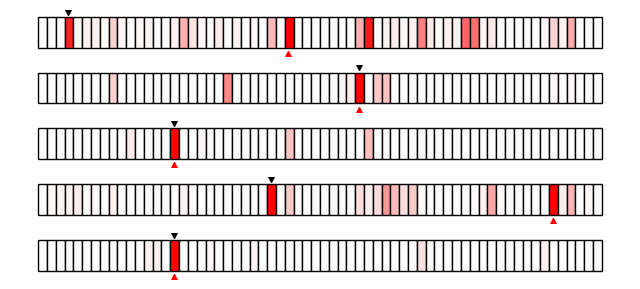

In [16]:
c_strings = df_data['context_long'].unique()
q_strings = np.array(list(question_embeddings.keys()))

def main(N=1):
    qs = np.random.choice(q_strings, N)
    q_embs = [question_embeddings[q] for q in qs]

    true_ctxs = [df_data.loc[df_data['question']==q, 'context_long'].values[0] for q in qs]
    true_ctx_idxs = [np.where(c_strings==true_ctx)[0][0] for true_ctx in true_ctxs]

    query_books = [np.array([np.concatenate((context_embeddings[ctx], q_emb)) for ctx in c_strings]) for q_emb in q_embs]
    outputs = [neural_net_b.predict(q_book) for q_book in query_books]
    outputs = [(z - z.min())/(z.max() - z.min()) for z in outputs]  # normalize
    best_ctx_idxs = [np.argmax(output) for output in outputs]

    length = len(contexts)
    fig, axs = plt.subplots(N, 1, figsize=(8, 0.7*N))
    for i in range(N):
        ax = axs[i]
        _, _, patches = ax.hist(range(length), length, edgecolor='black', linewidth=1)
        
        for j, v in enumerate(outputs[i]):
            patches[j].set_facecolor(color=colorFader('#fcfcfc', 'red', v))

        ax.plot([true_ctx_idxs[i] + .38 - true_ctx_idxs[i] * 0.015], [1.17], marker='v', markersize=4, color="k")  # True context
        ax.plot([best_ctx_idxs[i] + .38 - best_ctx_idxs[i] * 0.015], [-0.2], marker='^', markersize=4, color="red")  # True context
        # ax.axhline(0, 0.05, 0.95, color='black', linewidth=2.4) # Bottom line

        print(qs[i])

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.axis('off')
    
    plt.show()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

main(5)